## MACHINE TRANSLATION PROJECT (ENGLISH TO FRENCH)

In [2]:
import json
import numpy as np
import collections

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,GRU,LSTM,Embedding,Bidirectional,Dropout,Activation,TimeDistributed,RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

### TO see the GPU in system

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6602933179030257927
xla_global_id: -1
]


### LOADIND DATA

In [4]:
def load_data(path):
    input_file=path
    with open(input_file,"r") as f:
        data = f.read()
    return data.split('\n')
english_sentences = load_data("data/english")
french_sentences = load_data("data/french")


### Sample data

In [5]:
print(english_sentences[:5])
print(french_sentences[:5])


['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .', 'california is usually quiet during march , and it is usually hot in june .', 'the united states is sometimes mild during june , and it is cold in september .', 'your least liked fruit is the grape , but my least liked is the apple .']
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .', 'california est généralement calme en mars , et il est généralement chaud en juin .', 'les états-unis est parfois légère en juin , et il fait froid en septembre .', 'votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .']


In [6]:
english_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words'.format(len([word for sentence in english_sentences for word in sentence.split()] )))
print(f"Unique English Words {len(english_counter)}")
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_counter.most_common(10)))[0]) + '"')#get only the words zero indicates the first list contains only words
print(f"{english_counter.most_common(10)}")
print()

print('{} French words'.format(len([word for sentence in french_sentences for word in sentence.split()] )))
print(f"Unique rench Words {len(french_counter)}")
print('10 Most common words in the french dataset:')
#print('"' + '" "'.join(list(zip(*french_counter.most_common(10)))[0]) + '"')
print(f"{french_counter.most_common(10)}")


    

1823250 English words
Unique English Words 227
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"
[('is', 205858), (',', 140897), ('.', 129039), ('in', 75525), ('it', 75137), ('during', 74933), ('the', 67628), ('but', 63987), ('and', 59850), ('sometimes', 37746)]

1961295 French words
Unique rench Words 355
10 Most common words in the french dataset:
[('est', 196809), ('.', 135619), (',', 123135), ('en', 105768), ('il', 84079), ('les', 65255), ('mais', 63987), ('et', 59851), ('la', 49861), ('parfois', 37746)]


### PREPROCESSING

#### 1.TOKENIZATION
#### 2.PADDING

In [7]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x),tokenizer 
#tokenizer.text_to_sequence(x) retuns the sequnce
#tokenizer is like a tuple it contains a word with their index number to see print(tokenizer.word_index)


    

In [8]:
def pad(x,length=None):
    if length is None:
        length=max([len(sentence) for sentence in x])
    return pad_sequences(x,maxlen=length,padding='post')
# used to pad the values ex [1,2],[2,3,4],[1,2,3,4,5]
# result is [1,2,,0,0,0],[2,3,4,0,0],[1,2,3,4,5]
# padding='post' used pad values at last 
# The model takes only same length of values

### PEPROCESSING

In [9]:
def preprocess(x,y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)
    
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)
    
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape,1)
    
    return preprocess_x,preprocess_y,x_tk,y_tk

prepro_english_sentence,prepro_french_sentence,english_tokenizer,french_tokenizer = preprocess(english_sentences,french_sentences)

max_english_sequence_length = prepro_english_sentence.shape[1]
max_french_sequence_length = prepro_french_sentence.shape[1]
english_vocab_size = len(english_tokenizer.word_index) + 1
french_vocab_size = len(french_tokenizer.word_index) + 1

In [10]:
print("Preprocessed English Sentences:\n", prepro_english_sentence)
print("Preprocessed French Sentences:\n", prepro_french_sentence)
print("English Tokenizer Word Index:\n", english_tokenizer.word_index)
print("French Tokenizer Word Index:\n", french_tokenizer.word_index)
print()

# TO find the maximum values
print("Max value of Preprocessed English Sentences:\n", prepro_english_sentence.shape[1])
print("Max value of Preprocessed French Sentences:\n", prepro_french_sentence.shape[1])
print("Max value of English Tokenizer Word Index:\n", len(english_tokenizer.word_index))
print("Max value of French Tokenizer Word Index:\n", len(french_tokenizer.word_index))
print()

Preprocessed English Sentences:
 [[17 23  1 ... 44  0  0]
 [ 5 20 21 ... 51  2 45]
 [22  1  9 ... 34  0  0]
 ...
 [24  1 10 ... 54  0  0]
 [ 5 84  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Preprocessed French Sentences:
 [[[ 35]
  [ 34]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 [[  4]
  [ 32]
  [ 31]
  ...
  [  0]
  [  0]
  [  0]]

 [[101]
  [  1]
  [ 12]
  ...
  [  0]
  [  0]
  [  0]]

 ...

 [[  7]
  [ 33]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 [[ 84]
  [  1]
  [ 20]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]]
English Tokenizer Word Index:
 {'is': 1, 'in': 2, 'it': 3, 'during': 4, 'the': 5, 'but': 6, 'and': 7, 'sometimes': 8, 'usually': 9, 'never': 10, 'favorite': 11, 'least': 12, 'fruit': 13, 'most': 14, 'loved': 15, 'liked': 16, 'new': 17, 'paris': 18, 'india': 19, 'united': 20, 'states': 21, 'california': 22, 'jersey': 23, 'france': 24, 'china': 25, 'he': 26, 'she': 27, 'grapefruit': 28, 'your': 29, 'my': 30, 'his': 31, 'her': 32, 'fall

# Models

#### Model 1 simple RNN
#### Model 2 bidirectional RNN
#### Model 3 Embedding RNN

### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [11]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

##### Above function explanation
Original Mapping (tokenizer.word_index):

Maps words to unique integer indices.
Example: {'i': 1, 'love': 2, 'machine': 3, ...}
Reversed Mapping (index_to_words):

Maps integer indices back to words.
Example: {1: 'i', 2: 'love', 3: 'machine', ...}
Padding Index:

Adds a special entry for the padding index.
Example: {0: '<PAD>', 1: 'i', 2: 'love', ...}
This reversed mapping (index_to_words) is used in the logits_to_text function to convert the predicted indices back into readable words.

##### List Comprehension:

[index_to_words[prediction] for prediction in np.argmax(logits, 1)]

This is a list comprehension that iterates over the array of predicted indices.

For each predicted index (prediction), it looks up the corresponding word in the index_to_words dictionary.

Example:
Given index_to_words:
python
Copy code
{0: '<PAD>', 1: 'hello', 2: 'world', 3: 'test'}
For the predicted indices [1, 0, 2], the list comprehension will produce:
python
Copy code
['hello', '<PAD>', 'world']
' '.join(...):

The join method combines the list of words into a single string, with each word separated by a space.
"hello <PAD> world"

### MODEL 1 SIMPLE RNN

([], [])

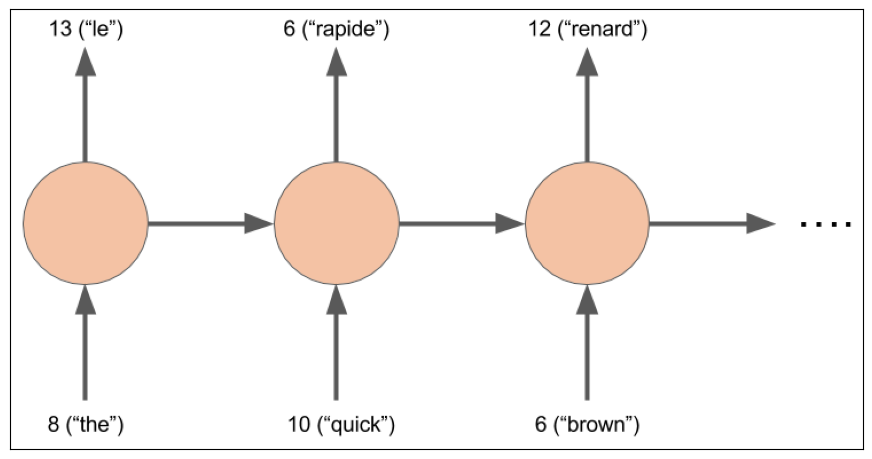

In [24]:
import cv2 as opencv
from matplotlib import pyplot as plt
img = opencv.imread("images/rnn.png")
plt.figure(figsize=(11,6))
plt.imshow(img)
plt.xticks([])
plt.yticks([])

simple rnn model has only one direction

In [13]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    #Hyperparameters
    learning_rate = 0.005
    
    # Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    # Compile model
    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer = Adam(learning_rate),
                  metrics = ['accuracy'])
    
    return model

tmp_x = pad(prepro_english_sentence, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, prepro_french_sentence.shape[-2], 1))

#Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

simple_rnn_model.fit(tmp_x, prepro_french_sentence, batch_size=1024, epochs=5, validation_split=0.2)

Epoch 1/5


c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.4549 - loss: 2.6926 - val_accuracy: 0.6227 - val_loss: 1.3427
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.6244 - loss: 1.3252 - val_accuracy: 0.6734 - val_loss: 1.1088
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6600 - loss: 1.1384 - val_accuracy: 0.6828 - val_loss: 1.0185
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6744 - loss: 1.0490 - val_accuracy: 0.6861 - val_loss: 0.9401
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6854 - loss: 0.9849 - val_accuracy: 0.6823 - val_loss: 0.9100


# prediction 

In [15]:
print("__Prediction__:")
print(logits_to_text(simple_rnn_model(tmp_x[:2])[0],french_tokenizer))
print("\nCorrect Translation:")
print(french_sentences[:2])

print("\nOriginal Text:")
print(english_sentences[:2])

__Prediction__:
paris jersey est parfois calme en mois et il il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .']

Original Text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']


In this rnn Some of the translation is correct, but totaly not correct because it is simple model

### MODEL 2 BIDIRECTIONAL RNN

([], [])

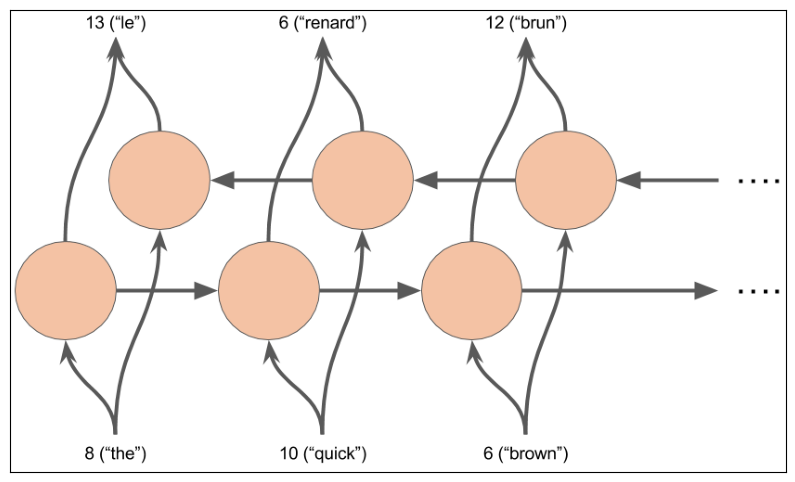

In [23]:
img = opencv.imread("images/bidirectional.png")
plt.figure(figsize=(11,6))
plt.imshow(img)
plt.xticks([])
plt.yticks([])

Bidirectional model, Data move from left to right and in another set of nodes data move from right to left

In [18]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    #Hyperparameters
    learning_rate = 0.005
    
    # Build the layers
    model = Sequential()
    model.add(Bidirectional(GRU(128,return_sequences=True),input_shape=input_shape[1:]))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    # Compile model
    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer = Adam(learning_rate),
                  metrics = ['accuracy'])
    
    return model

tmp_x = pad(prepro_english_sentence, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, prepro_french_sentence.shape[-2], 1))

#Train the neural network
bd_rnn_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(bd_rnn_model.summary())

bd_rnn_model.fit(tmp_x, prepro_french_sentence, batch_size=1024, epochs=10, validation_split=0.2)

c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 21, 256)        │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 21, 1024)       │       263,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 21, 345)        │       353,625 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 717,401 (2.74 MB)

 Trainable params: 717,401 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.5031 - loss: 2.4379 - val_accuracy: 0.6501 - val_loss: 1.2006
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6472 - loss: 1.2066 - val_accuracy: 0.6752 - val_loss: 1.0391
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6725 - loss: 1.0624 - val_accuracy: 0.7008 - val_loss: 0.9283
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.6877 - loss: 0.9708 - val_accuracy: 0.7114 - val_loss: 0.8557
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.6991 - loss: 0.9090 - val_accuracy: 0.7187 - val_loss: 0.8146
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7076 - loss: 0.8613 - val_accuracy: 0.7272 - val_loss: 0.7711
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.7115 - loss: 0.8326 - val_accuracy: 0.7362 - val_loss: 0.7390
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.7191 - loss: 0.7986 - val

In [19]:
print("__Prediction__:")
print(logits_to_text(bd_rnn_model(tmp_x[:2])[0],french_tokenizer))
print("\nCorrect Translation:")
print(french_sentences[:2])

print("\nOriginal Text:")
print(english_sentences[:2])

__Prediction__:
new jersey est parfois calme en mois de mai et il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .']

Original Text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']


### MODEL 3 EMBEDDING RNN MODEL

([], [])

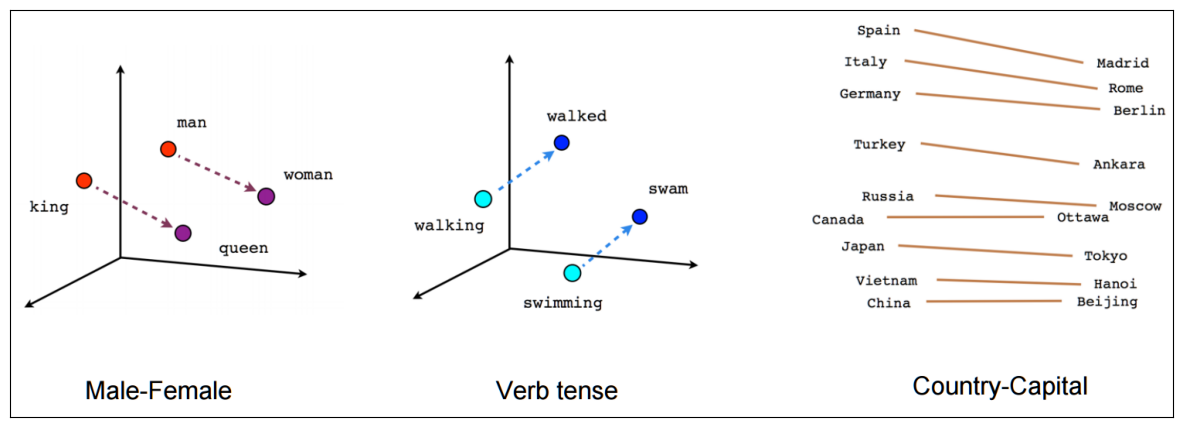

In [22]:
img = opencv.imread("images/embedding-words.png")
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.xticks([])
plt.yticks([])

You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In [28]:
def bidirectional_embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    # Hyperparameters
    learning_rate = 0.005
    
    # Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    # Compile model
    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer = Adam(learning_rate),
                  metrics = ['accuracy'])
    
    return model

ttmp_x = pad(prepro_english_sentence, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, prepro_french_sentence.shape[-2]))

#Train the neural network
embed_rnn_model = bidirectional_embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

print(embed_rnn_model.summary())

embed_rnn_model.fit(tmp_x, prepro_french_sentence, batch_size=1024, epochs=10, validation_split=0.2)

c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 21, 256)        │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 21, 512)        │       789,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 21, 1024)       │       525,312 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 21, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 21, 345)        │       353,625 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,719,641 (6.56 MB)

 Trainable params: 1,719,641 (6.56 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.5995 - loss: 2.0667 - val_accuracy: 0.8822 - val_loss: 0.3723
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8925 - loss: 0.3401 - val_accuracy: 0.9401 - val_loss: 0.1901
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9421 - loss: 0.1850 - val_accuracy: 0.9610 - val_loss: 0.1277
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9586 - loss: 0.1328 - val_accuracy: 0.9705 - val_loss: 0.0975
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9683 - loss: 0.1020 - val_accuracy: 0.9743 - val_loss: 0.0847
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 406s 4s/step - accuracy: 0.9737 - loss: 0.0847 - val_accuracy: 0.9773 - val_loss: 0.0752
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9769 - loss: 0.0739 - val_accuracy: 0.9800 - val_loss: 0.0692
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9790 - loss: 0.0675 - val

In [29]:
# Print prediction(s)
print("Prediciton:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print('\nOriginal text:')
print(english_sentences[:1])

Prediciton:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


### SERIALIZE TOKENIZER TO JSON AND SAVE MODEL

In [33]:
# Save the model with the recommended .keras extension
embed_rnn_model.save('english_to_french_model.keras')

# Serialize English Tokenizer to JSON
with open('english_tokenizer.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(english_tokenizer.to_json(), ensure_ascii=False))
    
# Serialize French Tokenizer to JSON
with open('french_tokenizer.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(french_tokenizer.to_json(), ensure_ascii=False))
    
# Save max lengths
max_french_sequence_length_json = max_french_sequence_length
with open('sequence_length.json', 'w', encoding='utf8') as f:
    f.write(json.dumps(max_french_sequence_length_json, ensure_ascii=False))